# Check output of SMICA for residuals, on map and powerspectrum level and compare it against Maudes raw data (DCSP intermediate data I assume)
This can be put into the appendix of the paper

## Header

In [5]:
%%capture
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import matplotlib.gridspec as gridspec
from scipy.signal import savgol_filter as sf
import json
import copy
from astropy.io import fits
import copy
import component_separation.spherelib.python.spherelib.astro as slhpastro
from scipy import interpolate

import healpy as hp
import component_separation
from component_separation.io import IO

from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen as fn_gen
from component_separation.cs_util import Filename_gen_SMICA as fns_gen

import component_separation.powerspectrum as pw
import component_separation.covariance as cv
import matplotlib.pyplot as plt

csu = Config(freqdset='DX12', mskset='smica', spectrum_type='pseudo')
# csu = Config(mskset='smica')
simid = -1

io = IO(csu)
fn = fn_gen(csu)
fns = fns_gen(csu)

TEB = 1
TEB = TEB
Tscale ='K_RJ'

In [6]:
lmax = csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.FREQ_f
specfilter = csu.specfilter
freqfilter = csu.FREQFILTER
colors = csu.CB_color_cycle
bcorr = np.array([
    hp.gauss_beam(val, lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ])
beam5 = hp.gauss_beam(0.00145444, lmax, pol = True)[:,1]
beam5_binned = hpf.bin_it1D(beam5, bins=bins)


from component_separation.config_planck import BeamfDX12, BeamfNPIPE
beamfDX12 = io.load_beamf(csu.freqcomb, csu.lmax, csu.freqdatsplit)
BeamfNPIPE = io.load_beamf(csu.freqcomb, csu.lmax, csu.freqdatsplit)

In [8]:
Cltot = io.load_data(fn.get_spectrum("T", "non-separated", simid=simid))
covltot = cv.build_covmatrices(Cltot, Tscale, csu.FREQ_f)

ClN = io.load_data(fn.get_spectrum("N", "non-separated", simid=simid))
covlN = cv.build_covmatrices(ClN, Tscale, csu.FREQ_f)

ClS = io.load_data(fns.get_spectrum("S", "non-separated", simid=simid))
covlS = cv.build_covmatrices(ClS, Tscale, csu.FREQ_f)

smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
for k, v in smica_params.items():
    smica_params[k] = io.load_data(fns.get_misc(k, simid=simid))
    
    
W_smica = io.load_data(fns.get_misc('w', simid=simid))
W_mv = io.load_data(fn.get_misc('w', simid=simid))
W_total = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)
W_total[:,:,0:2] = 0.0

smica_param = dict({'cov': None, "cov4D": None, "CMB": None, "gal": None, "gal_mm": None, "w": None})
for k, v in smica_param.items():
    smica_param[k] = io.load_data(fns.get_misc(k))

loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClT_non-separated_2048_4000_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClN_non-separated_2048_4000_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/Sest/ClS_NPIPEsim.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_cov_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_cov4D_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_CMB_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_gal_mm_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_w_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_w_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/w_pseudo.npy
l

In [9]:
W_total_propag = np.loadtxt("/global/homes/s/sebibel/ext/smica_propagation/weights_EB_smica_R3.00.txt").reshape(2,7,4001)

# Load Maudes DX12 results and compare
Comparison only sensible when data is in $K_{RJ}$ scale

In [10]:
md_N = np.loadtxt("/global/homes/s/sebibel/data/maude/N.txt").reshape(7,37)
md_A = np.loadtxt("/global/homes/s/sebibel/data/maude/A.txt").reshape(7,7)

md_P = np.loadtxt("/global/homes/s/sebibel/data/maude/P.txt").reshape(7,7,37)

md_hR = np.loadtxt("/global/homes/s/sebibel/data/maude/hR_binned_full.txt").reshape(7,7,37)
md_Rl = np.loadtxt("/global/homes/s/sebibel/data/maude/Rl.txt").reshape(7,7,4001)

md_w_raw = np.loadtxt("/global/homes/s/sebibel/data/maude/raw_filter_cmb_full.txt").reshape(2,7,4001)
md_w_mc= np.loadtxt("/global/homes/s/sebibel/data/maude/mc_filter_cmb_full.txt").reshape(2,7,4001)
md_w = np.loadtxt("/global/homes/s/sebibel/data/maude/w_binned_full.txt")

md_bins = np.loadtxt("/global/homes/s/sebibel/data/maude/bins.txt")

## W_ell hR_ell W_ell^T

In [13]:
lmaxbin = lmax
print(lmax)
res_tot_M = np.zeros(shape=(lmaxbin))
res_tot_S = np.zeros(shape=(lmaxbin))
for l in range(lmaxbin):
    res_tot_M[l] = np.dot(np.dot(
        (md_w_mc[0,:,l]*np.nan_to_num(np.diag(beamfDX12[TEB,:,:,l]))/beam5[l]).T,md_Rl[:,:,l]/beam5[l]**2),md_w_mc[0,:,l]*np.nan_to_num(np.diag(beamfDX12[TEB,:,:,l]))/(beam5[l]))
    res_tot_S[l] = np.dot(np.dot((W_total[TEB,:,l]).T,np.nan_to_num(covltot[TEB,:,:,l])),W_total[TEB,:,l])

4000


(-0.2, 0.2)

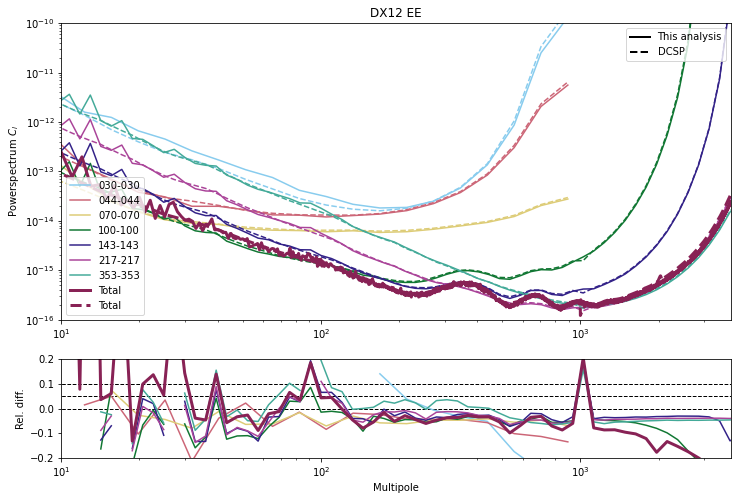

In [18]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for n in range(0,md_P.shape[0]):
    for m in range(0,md_P.shape[0]):
        if n == m:
            lmx_loc = 800 if n < 3 else 4000
            lspc = np.logspace(0,3, 30) if n < 3 else np.logspace(0, 4.0, 100)
            lsbins = lspc[:-1]
            rsbins = lspc[1:]
            md_Rl_loc = copy.copy(md_Rl)
            logbins = np.array([[n,m] for n,m in zip(lsbins, rsbins)])
            md_sc = md_Rl_loc[n,m,:lmx_loc]*1e-6/beam5[:lmx_loc]**2

            ax0.plot(
                np.mean(logbins, axis=1),
                hpf.bin_it1D(covltot[TEB, n,m,:lmx_loc],bins=logbins),
                color=colors[n], label="{}-{}".format(csu.FREQ[n],csu.FREQ[m]))
            
            ax0.plot(np.mean(logbins, axis=1), hpf.bin_it1D(md_sc,bins=logbins),
                     color=colors[m], ls= '--')
            buff = hpf.bin_it1D(covltot[TEB,n,m,:lmx_loc],bins=logbins)/\
                    hpf.bin_it1D(md_sc, bins=logbins)-1
            buff[buff>0.2]=None
            ax1.plot(np.mean(logbins, axis=1), buff, color=colors[n], label="{}-{}".format(csu.FREQ[n],csu.FREQ[m]))
            
res_tot_M_loc = copy.copy(res_tot_M)
# res_tot_M_loc[990:1050] = None
ax0.plot(res_tot_S, label = 'Total', color=colors[8], lw=3)
ax0.plot(res_tot_M_loc*1e-6, label = 'Total', color=colors[8], lw=3, ls='--')

lspc = np.logspace(0, 4.0, 100)
lsbins = lspc[:-1]
rsbins = lspc[1:]
logbins = np.array([[n,m] for n,m in zip(lsbins, rsbins)])
buff = hpf.bin_it1D(res_tot_S / res_tot_M_loc*1e6 - 1,bins=logbins)
ax1.plot(np.mean(logbins, axis=1), buff, color=colors[8], lw=3)
soliddummy, = plt.plot(0,0,ls='-', color='black', lw=2)
dasheddummy, = plt.plot(0,0,ls='--', color='black', lw=2)

ax1.hlines(1e-1,0,4000, color='black', ls = '--', lw=1)
ax1.hlines(0,0,4000, color='black', ls = '--', lw=1)
ax1.hlines(5e-2,0,4000, color='black', ls = '--', lw=1)

leg1 = ax0.legend(loc='lower left')
leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','DCSP'], loc='upper right')
ax0.add_artist(leg1)

ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_xlim((1e1,3800))
ax0.set_ylim((1e-16,1e-10))
ax0.set_title('DX12 {}'.format('EE'))
ax0.set_ylabel(r'Powerspectrum $C_l$')

ax1.set_xlabel('Multipole')
ax1.set_ylabel('Rel. diff.')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim((1e1,3800))
ax1.set_ylim((-0.2,0.2))

## W_ell N_ell W_ell^T

In [19]:
lmaxbin = lmax#len(bins)
res_N_M = np.zeros(shape=(37))
res_N_S = np.zeros(shape=(lmaxbin))
cov_md_N = np.zeros(shape = (7,7,37))
md_w_mc_binned = np.zeros(shape=(7,37))
bf_binned = np.array([hpf.bin_it1D(beamfDX12[1,n,n,:], bins=bins) for n in range(beamfDX12.shape[1])])

for n in range(md_w_mc_binned.shape[0]):
    md_w_mc_binned[n] = hpf.bin_it1D(md_w_mc[0,n,:], bins=bins) #*bcorr[n]/(beam5)
for l in range(37):
    np.fill_diagonal(cov_md_N[:,:,l], md_N[:,l])
for l in range(37):
    res_N_M[l] = np.dot(np.dot((md_w_mc_binned[:,l]*bf_binned[:,l]/beam5_binned[l]).T,cov_md_N[:,:,l]*1e6/beam5_binned[l]**2),md_w_mc_binned[:,l]*bf_binned[:,l]/beam5_binned[l])

for l in range(lmaxbin):
    res_N_S[l] = np.dot(np.dot(W_total[TEB,:,l].T,covlN[TEB,:,:,l]*1e12),W_total[TEB,:,l])

Text(0, 0.5, 'Rel. Diff.')

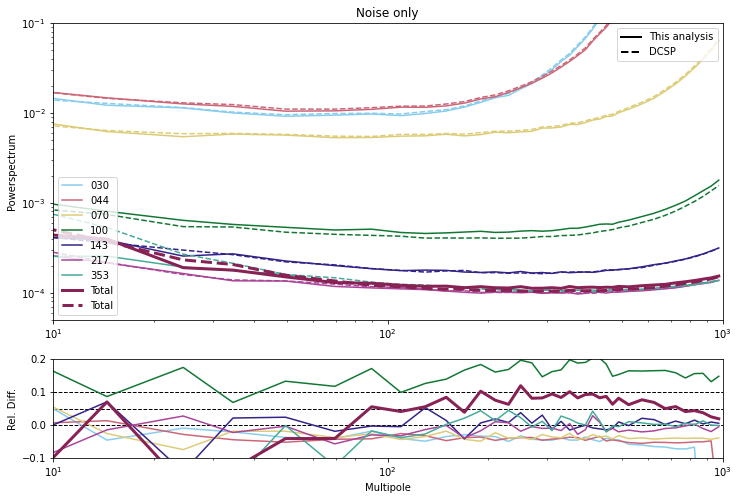

In [20]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for n in range(0,md_N.shape[0]):
    lspc = np.logspace(0,3, 30) if n < 3 else np.logspace(0, 4.0, 100)
    lsbins = lspc[:-1]
    rsbins = lspc[1:]
    logbins = np.array([[n,m] for n,m in zip(lsbins, rsbins)])
    averaged = hpf.bin_it1D(covlN[TEB,n,n]*1e12,bins=bins)
    ax0.plot(np.mean(bins, axis=1), averaged, color=colors[n], label="{}".format(csu.FREQ[n]))
    ax0.plot(np.mean(bins, axis=1), md_N[n]/beam5_binned**2*1e6, color=colors[n], ls='--')
    
    buff = (averaged)/(md_N[n]/hpf.bin_it1D(beam5, bins=bins)**2*1e6)-1
    ax1.plot(np.mean(bins, axis=1), buff, color=colors[n])

ax0.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_N_S, bins=bins), label='Total', color=colors[8], lw=3)
ax0.plot(np.mean(bins, axis=1), res_N_M, label='Total', color=colors[8], lw=3, ls='--')
ax1.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_N_S, bins=bins)/res_N_M-1, label='Total', color=colors[8], lw=3)

ax0.set_title('Noise only')
leg1 = ax0.legend(loc='lower left')
leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','DCSP'], loc='upper right')
ax0.add_artist(leg1)

ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_xlim((10,1e3))
ax0.set_ylim((5e-5,1e-1))
ax0.set_ylabel('Powerspectrum')

ax1.hlines(1e-1,0,4000, color='black', ls = '--', lw=1)
ax1.hlines(0,0,4000, color='black', ls = '--', lw=1)
ax1.hlines(5e-2,0,4000, color='black', ls = '--', lw=1)

ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim((10,1e3))
ax1.set_ylim((-0.1,0.2))
ax1.set_xlabel('Multipole')
ax1.set_ylabel('Rel. Diff.')

## W_ell Rg_ell W_ell^T

In [25]:
lmaxbin = lmax
md_Rg = np.zeros(shape=(7,7,37))
cov_gal = np.zeros(shape=(7,7,len(bins)))
for l in range(37):
    cov_gal[:,:,l] = smica_param['gal_mm'][TEB-1] @ smica_param['gal'][TEB-1,:,:,l] @ smica_param['gal_mm'][TEB-1].T

md_Pg = md_P[1:,1:,:]
md_Ag = md_A[:,1:] 
print(md_Ag.shape, md_Pg.shape)
for l in range(0,37):
    md_Rg[:,:,l] = md_Ag @ md_Pg[:,:,l] @ md_Ag.T

(7, 6) (6, 6, 37)


In [26]:
res_G_M = np.zeros(shape=(2,37))
res_G_S = np.zeros(shape=len(bins))
md_Rg_buf = np.zeros_like(md_Rg)

for n in range(7):
    md_Rg_buf[n,n,:] = md_Rg[n,n,:]*1e6/beam5_binned**2
for l in range(37):
    res_G_S[l] = np.dot(np.dot(W_smica[0,:,l].T,cov_gal_fac[:,:,l]),W_smica[0,:,l])
    # res_G_S[l] = np.dot(np.dot(W_smica[1,:,l].T,md_Rg_buf[:,:,l]),W_smica[1,:,l])

md_w_mc_beamed = np.zeros(shape=(2,7,4001))
W_total_propag_beamed = np.zeros(shape=(2,7,4001))
for m in range(2):
    for l in range(0,4001):
        for n in range(0,7):
            md_w_mc_beamed[m,n,l] = md_w_mc[m,n,l] * bcorr[n,l]/beam5[l]
            W_total_propag_beamed[m,n,l] = W_total_propag[m,n,l] * bcorr[n,l]/beam5[l]
md_w_mc_beamed_bnd = np.zeros(shape=(2,7,37))
for m in range(2):
    for n in range(0,7):
        md_w_mc_beamed_bnd[m,n] = hpf.bin_it1D(md_w_mc_beamed[m,n], bins=bins)
for m in range(2):
    for l in range(37):
        res_G_M[m,l] = np.dot(np.dot(md_w_mc_beamed_bnd[m,:,l].T,md_Rg_buf[:,:,l]),md_w_mc_beamed_bnd[m,:,l])
#     res_G_M[l] = np.dot(np.dot(W_smica[1,:,l].T,md_Rg[:,:,l]*1e6/beam5_binned[l]**2),W_smica[1,:,l])
#     res_G_M[l] = np.dot(np.dot(md_w_mc_beamed[:,l].T,md_Rg[:,:,l]*1e6),md_w_mc_beamed[:,l])

NameError: name 'cov_gal_fac' is not defined

In [ ]:
for ipos, pos in enumerate(['EE', 'BB']):
    plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    soliddummy, = plt.plot(0,0,ls='-', color='black', lw=2)
    dasheddummy, = plt.plot(0,0,ls='--', color='black', lw=2)
    
    cov_gal_fac = np.zeros_like(cov_gal)
    for n in range(7):
        factor = slhpastro.convfact(freq=int(csu.FREQ[n])*1e9, fr='K_CMB',to=Tscale)
        cov_gal_fac[n,n] = cov_gal[n,n]*1e12*factor**2
    for n in range(7):
        ax0.plot(np.mean(bins, axis=1), cov_gal_fac[n,n,:], color=colors[n], label=csu.FREQ[n])
        ax0.plot(np.mean(bins, axis=1), md_Rg[n,n,:]*1e6/beam5_binned**2, color=colors[n], ls='--')
        if n >3:
            ax1.plot(np.mean(bins, axis=1), cov_gal_fac[n,n,:]/(md_Rg[n,n,:]*1e6/beam5_binned**2)-1, color=colors[n], ls='-')

    ax0.plot(np.mean(bins, axis=1), res_G_S, lw=3, color=colors[8], label='Total')
    ax0.plot(np.mean(bins, axis=1), res_G_M[ipos], lw=3, color=colors[8], label='Total', ls='--')
    ax1.plot(np.mean(bins, axis=1), res_G_S/res_G_M[ipos]-1, color=colors[8], lw=3)
    ax1.hlines(1e-1,0,1000, color='black', ls='--', lw=1)
    ax1.hlines(5e-2,0,1000, color='black', ls='--', lw=1)
    ax1.hlines(0,0,1000, color='black', ls = '--', lw=1)

    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax0.set_ylim((1e-5,5e0))
    ax0.set_xlim((10,1000))
    ax0.set_title('Foregrounds only, {}'.format(pos))
    ax0.set_ylabel(r'Powerspectrum $C_l$')

    # plt.xscale('log')
    leg1 = ax0.legend(loc='lower left')
    leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','DCSP'], loc='upper right')
    ax0.add_artist(leg1)

    ax1.set_xscale('log')
    ax1.set_ylabel(r'Rel. diff.')
    ax1.set_xlabel('Mutlipole')
    ax1.set_xlim((10,1000))
    ax1.set_ylim((-0.2,0.2))
    plt.show()
    print('--')

## Weights

NameError: name 'md_w_mc_beamed' is not defined

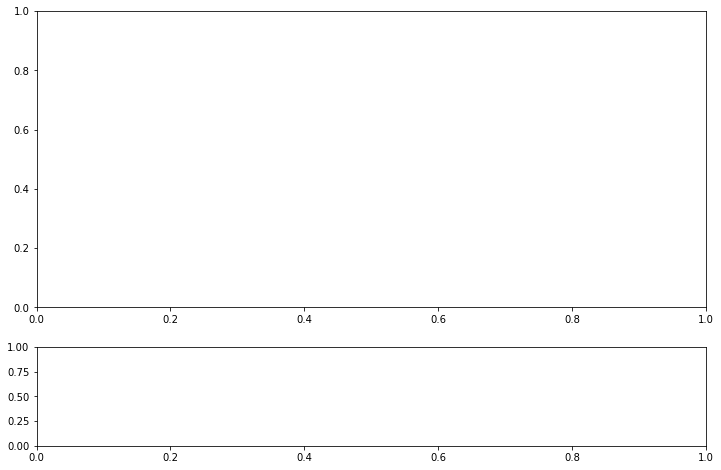

In [23]:
for m, pos in enumerate(['EE', 'BB']):
    plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    md_w_mc_beamed_loc = W_total_propag_beamed if m ==1 else md_w_mc_beamed
    for n in range(7):
        ax0.plot(W_total[m+1,n,:], color= colors[n],label=csu.FREQ[n])
        ax0.plot(md_w_mc_beamed_loc[m,n,:], color= colors[n], ls = '--')
        buff = (W_total[m+1,n,:] - md_w_mc_beamed_loc[m,n,:] )
        ax1.plot(buff, color=colors[n])

    leg1 = ax0.legend(loc='center right')
    leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','DCSP'], loc='upper right')
    ax0.add_artist(leg1)

    ax0.set_ylim((-0.1,0.6))
    ax0.set_xlim((5,998))
    ax0.set_ylabel('Weights')
    ax0.set_title('DX12 {}'.format(pos))
    
    ax1.set_ylabel('Rel. Diff.')
    ax1.set_xlabel('Mutlipole')
    ax1.set_ylim((-0.01,0.01))
    ax1.set_xlim((5,998))
    ax1.hlines(0,0,1000, color='black', ls='--', lw=1)
    plt.show()
    print('--')

# All Residuals in one plot

## Mine
The following plot is only consistent when data is in $K_{CMB}$ scale

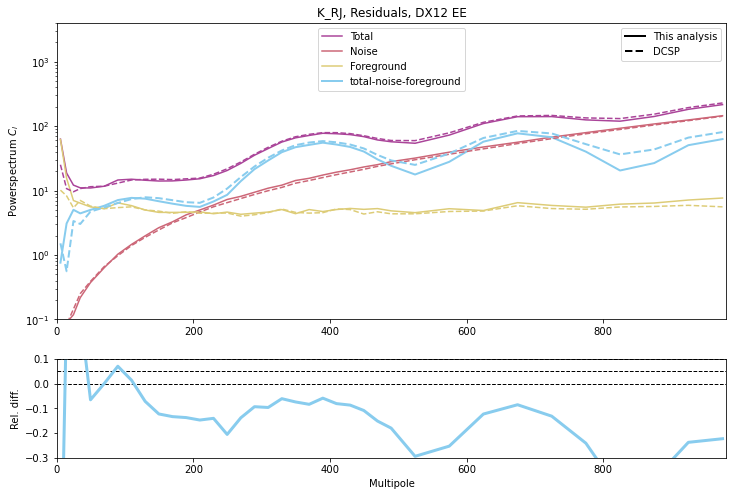

--


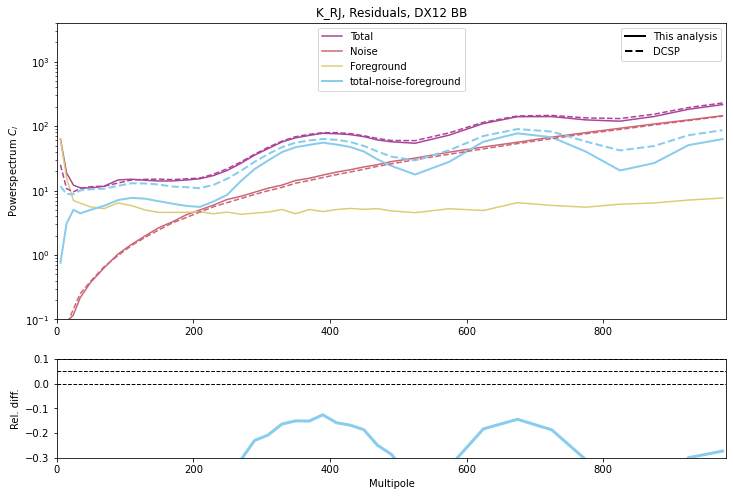

--


In [236]:
def ll(l):
    return (l*(l+1))
bin_ell = ll(np.mean(bins, axis=1))
all_ell = ll(np.arange(0,4000,1))

for m, pos in enumerate(['EE', 'BB']):
    plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_tot_S*1e12, bins=bins)*bin_ell, label='Total', color=colors[5])
    ax0.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_N_S, bins=bins)*bin_ell, label='Noise', color=colors[1])
    ax0.plot(np.mean(bins, axis=1), res_G_S*bin_ell, label='Foreground', color=colors[2])
    ax0.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_S*1e12, bins=bins)-hpf.bin_it1D(res_N_S, bins=bins)-res_G_S)*bin_ell, label='total-noise-foreground', color=colors[0], lw=2)

    ax0.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_tot_M*1e6, bins=bins)*bin_ell, color=colors[5], ls='--')
    ax0.plot(np.mean(bins, axis=1), res_N_M*bin_ell, color=colors[1], ls='--')
    ax0.plot(np.mean(bins, axis=1), res_G_M[m]*bin_ell, color=colors[2], ls='--')
    ax0.plot(np.mean(bins, axis=1), hpf.bin_it1D(res_tot_M*all_ell*1e6, bins=bins)-(res_N_M+res_G_M[m])*bin_ell, color=colors[0], lw=2, ls='--')

    leg1 = ax0.legend(loc='upper center')
    leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','DCSP'], loc='upper right')
    ax0.add_artist(leg1)
    
    ax1.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_S*1e12, bins=bins)-hpf.bin_it1D(res_N_S, bins=bins)-res_G_S)/(hpf.bin_it1D(res_tot_M*1e6, bins=bins)-res_N_M-res_G_M[m])-1, lw=3, color=colors[0])
    ax1.hlines(1e-1,0,1000, color='black', ls='--', lw=1)
    ax1.hlines(5e-2,0,1000, color='black', ls='--', lw=1)
    ax1.hlines(0,0,1000, color='black', ls = '--', lw=1)
    
    ax0.set_yscale('log')
    ax0.set_ylim((1e-1,4e3))
    ax0.set_xlim((0,980))
    ax0.set_ylabel(r'Powerspectrum $C_l$')
    ax0.set_title('{}, Residuals, {} {}'.format(Tscale, csu.freqdset, pos))
    
    ax1.set_ylabel(r'Rel. diff.')
    ax1.set_xlabel('Multipole')
    ax1.set_ylim((-0.3,0.1))
    ax1.set_xlim((0,980))
    plt.show()
    print('--')

# Backup

## Maude TBD
Maudes data is D_l in K_RJ scale

Text(0, 0.5, 'Powerspectrum')

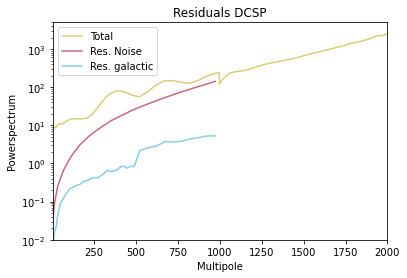

In [20]:
%matplotlib inline
def ll(l):
    return (l*(l+1))

bin_ell = ll(np.mean(bins, axis=1))
all_ell = ll(np.arange(0,4000,1))
plt.plot(res_tot_M*all_ell, label='Total', color = colors[2])
plt.plot(np.mean(bins, axis=1), res_N_M*bin_ell, label='Res. Noise', color = colors[1])
plt.plot(np.mean(bins, axis=1), res_G_M*md_w*1e-5*bin_ell, label='Res. galactic', color = colors[0])

plt.yscale('log')
plt.ylim((1e-2,5e3))
plt.xlim((5,2000))
plt.title('Residuals DCSP')
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

# Compare weights (DX12 smica only)
W_smica = io.load_data(io.fh.weight_smica_path_name)
 * "- raw_filter_cmb_full.txt: weights derived from the fit (A^T R-1 A)^-1 A^T R^-1"
 * md_w_mc looks familiar
 * md_w = what is that?

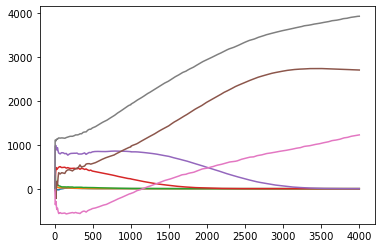

In [55]:
%matplotlib inline
for n in range(0,7):
    plt.plot(md_w_raw[0,n])
plt.plot(np.sum(md_w_raw[0,:],axis=0))

----------------------------------------------
# Other

## Derive Maudes weights etc.
md_R = md_hR = md_Rl[:1000]

BUT why are 217 and 353 constant for high ell?

In [25]:
md_fg = np.zeros(shape=(7,7,37))
md_R = np.zeros(shape=(7,7,37))
AP = np.zeros(shape=(7,7,37))
for l in range(0,37):
    AP[1,:,l] = np.dot(md_A, md_P[:,:,l])
    md_fg[:,:,l] = np.dot(AP[:,:,l], md_A.T)
for l in range(0,37):
    for n in range(0,7):
        md_R[n,n,l] = md_fg[n,n,l]# + md_N[n,l]

ValueError: could not broadcast input array from shape (7,7) into shape (7)

In [9]:
%matplotlib inline
for n in range(7):
    plt.plot(np.mean(bins, axis=1), md_R[n,n,:], color=colors[n],label = csu.FREQ[n])
#     plt.plot(md_Rl[n,n,:], color=colors[n], ls= '--')
#     plt.plot(np.mean(bins, axis=1), md_hR[n,n,:])
plt.yscale('log')
plt.ylabel('Powerspectrum')
plt.legend()
plt.xlabel('Multipole')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Multipole')

## w_binned_full.txt

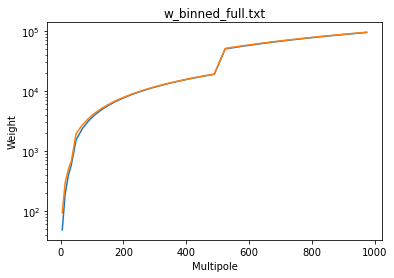

In [129]:
%matplotlib inline
plt.plot(np.mean(bins, axis=1), md_w)
plt.title('w_binned_full.txt')
plt.yscale('log')
plt.ylabel('Weight')
plt.xlabel('Multipole')

plt.plot(np.mean(binshl, axis=1), nmodes_smicahl)
# plt.plot(np.mean(binshl, axis=1), nmodes_lenshl)
# plt.plot(np.mean(binsll, axis=1), nmodes_smicall)
# plt.plot(np.mean(binsll, axis=1), nmodes_lensll)

## raw_filter_cmb_full

In [13]:
%matplotlib widget
for n in range(md_P.shape[0]):
    plt.plot(md_w_raw[0,n,:], label = csu.FREQ[n], color=colors[n])
plt.legend()
plt.title('raw_filter_cmb_full.txt')
plt.yscale('log')
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### (A^T R-1 A)^-1 A^T R^-1 = 'raw_filter_cmb_full.txt'
 * R here is md_R or md_Rl, the later for large ell
 * A here is sed

In [11]:
print(TSCALE)
TSCALE = "K_RJ"
w = np.zeros(shape=(7,4001))
a = np.ones(shape=(7))
import component_separation.transform_map as trsf_m
a = np.array([trsf_m.tcmb2trj_sc(FREQ, fr=r'K_CMB', to=TSCALE) for FREQ in csu.FREQ_f])
# a = md_A
for l in range(0,4001):
    denom = 1/(a.T @ np.linalg.inv(md_Rl[:,:,l]) @ a)
    nom = a.T @ np.linalg.inv(md_Rl[:,:,l])
    w[:,l] = np.dot(denom, nom)

K_CMB


BUT: only when multiplied by *1e-3

In [12]:
%matplotlib widget
for n in range(7):
    plt.plot(w[n], color=colors[n], label = csu.FREQ[n], alpha=0.5)
    plt.plot(md_w_raw[0,n,:]*1e-3, color=colors[n], ls = '--', lw = 1)
plt.legend()
plt.title('filters / weights')
plt.ylabel('Weight')
plt.xlabel('Multipole')
plt.yscale('log')
plt.xlim((100,4e3))
# plt.ylim((1e-6,1e0))
# plt.xscale('log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(100.0, 4000.0)